In [8]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config, Simulation
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
print(os.getcwd())

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks


## Parameters

#### Lorenz attractor simulation parameters

We simulate here 9 different possible Lorenz attractor configurations, essentially modifying the parameter $r$ that governs the behavior of the system. 

As a reminder, here is how the behavior of the system is affected by the parameter $r$:

- $0<r<1$ : 1 stable attractor
- $1<r<\sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$ : 2 stable attractors
- $r>\sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$ : 3 unstable attractors

For each of the three cases above, we chose to take 3 Lorenz configurations. For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

In [10]:
config = load_config('../config.yaml')

# Define parameters
dt = 0.01
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']
orders = config['simulations']['order']

## Simulation

Here we simulate all possible Lorenz traces according to the parameters mentioned above

In [11]:
simulations = []
for condition in lorenz_parameters:
    for i in range(len(lorenz_parameters[condition])):
        sim = Simulation(num_samples, num_steps, dt)
        pattern = lorenz_parameters[condition][i]
        sim.simulation_lorenz(pattern)
        simulations.append(sim)

In [12]:
simulations

In [13]:
simulations[8].simulation

array([[[0.34046517, 0.33833302, 0.33914719],
        [0.34025195, 0.33990431, 0.33910293],
        [0.34021719, 0.34135416, 0.33906712],
        ...,
        [0.25614952, 0.24553336, 0.64354918],
        [0.2550879 , 0.24657684, 0.64757127],
        [0.2542368 , 0.24815293, 0.65150515]],

       [[0.34054691, 0.33955906, 0.33983712],
        [0.34044812, 0.34052641, 0.33980685],
        [0.34045595, 0.34143499, 0.33978018],
        ...,
        [0.26099086, 0.25189286, 0.6404698 ],
        [0.26008106, 0.25233771, 0.64343855],
        [0.25930673, 0.25315497, 0.64640013]],

       [[0.34459432, 0.34079898, 0.33995154],
        [0.34421479, 0.3431957 , 0.33995496],
        [0.34411288, 0.34537876, 0.33997506],
        ...,
        [0.26382217, 0.26911731, 0.65394091],
        [0.26435168, 0.2709126 , 0.65434886],
        [0.26500777, 0.27273272, 0.65446298]],

       ...,

       [[0.34031398, 0.34324003, 0.33904562],
        [0.34060658, 0.34421964, 0.33904131],
        [0.34096789, 0

In [14]:
# create new simulations average list which contains average each element of simulations over first dimension
simulations_average = []
for i in range(len(simulations)):
    average_sim = np.mean(simulations[i].simulation, axis=0)
    simulations_average.append(np.broadcast_to(average_sim, (num_samples, num_steps,3)))

## Visualization

Visualization of one of the $200$ possible initializations for each of the nine possible Lorenz configurations

In [17]:
# model = [simulations[i].simulation[50,:,:] for i in range(9)]
model = [simulations_average[i] for i in range(9)]
model_names = ['One attractor config 1', 'One attractor config 2', 'One attractor config 3','Two stable attractors config 1', 'Two stable attractors config 2', 'Two stable attractors config 3', 'Two unstable attractors config 1', 'Two unstable attractors config 2', 'Two unstable attractors config 3']


for i in range(len(model)):
   fig = plt.figure()
   ax = fig.add_subplot(projection='3d')
   xyzs = model[i]
   to_plot = xyzs
   # Plot trajectory of first 
   ax.plot(*to_plot.T, lw=0.5)
   
   # ax.scatter(*fourth, color='black')
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.set_title(model_names[i])
   plt.show()
   

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (40000,)  and requested shape (200,)

Error in callback <function _draw_all_if_interactive at 0x118489760> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'Line3D' object has no attribute '_verts3d'

AttributeError: 'Line3D' object has no attribute '_verts3d'

<Figure size 640x480 with 1 Axes>

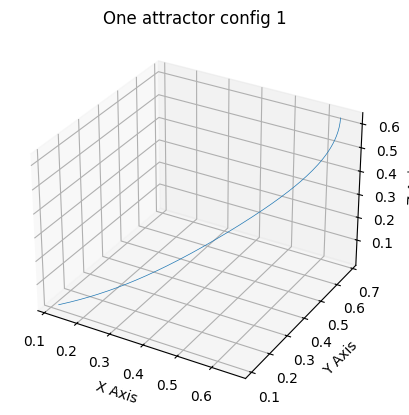

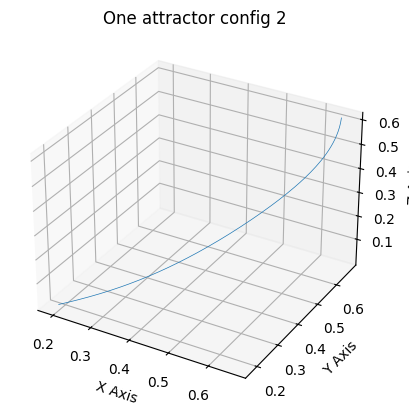

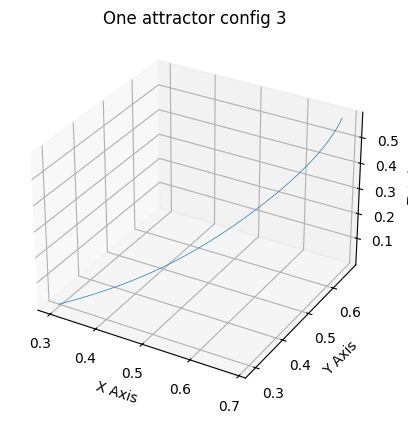

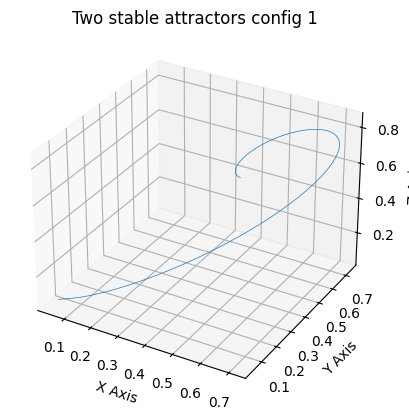

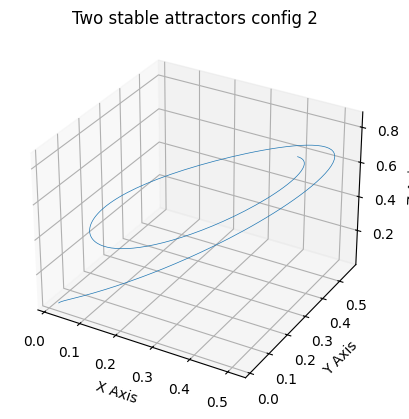

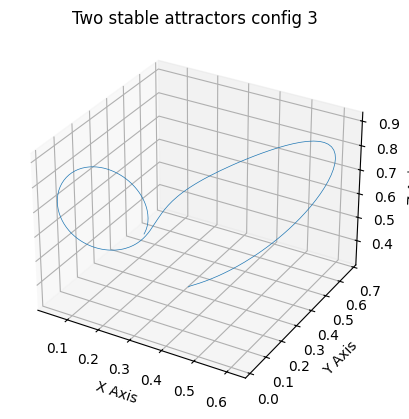

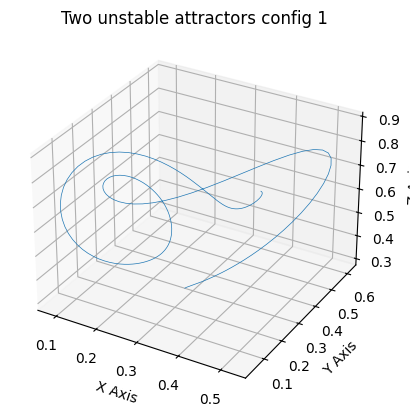

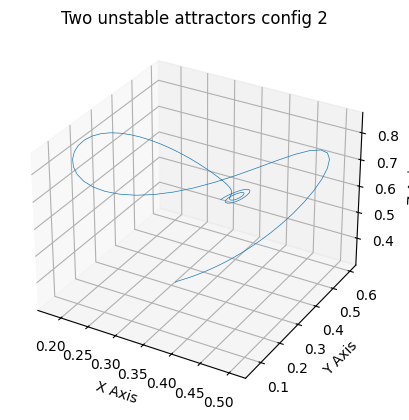

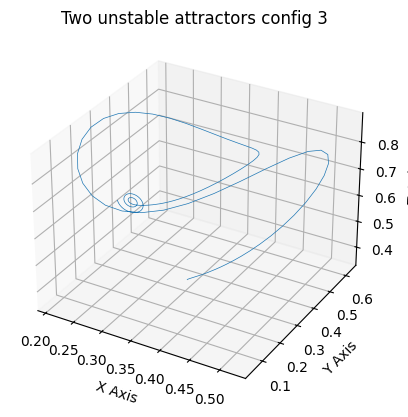

In [18]:
model = [simulations_average[i][50,:,:] for i in range(9)]
model_names = ['One attractor config 1', 'One attractor config 2', 'One attractor config 3','Two stable attractors config 1', 'Two stable attractors config 2', 'Two stable attractors config 3', 'Two unstable attractors config 1', 'Two unstable attractors config 2', 'Two unstable attractors config 3']


for i in range(len(model)):
   fig = plt.figure()
   ax = fig.add_subplot(projection='3d')
   xyzs = model[i]
   to_plot = xyzs
   # Plot trajectory of first 
   ax.plot(*to_plot.T, lw=0.5)
   
   # ax.scatter(*fourth, color='black')
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.set_title(model_names[i])

   plt.show()

## DSA analysis

Computations of the similarity metric between each of the 9 possible configurations, according to [1]

In [19]:
# model = [simulations[i].simulation for i in range(9)]
model = [simulations_average[i] for i in range(9)]

In [20]:
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")

In [21]:
procrustes_scores = np.empty((len(model),len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        procrustes_scores[i,j] = procrustes_measure(model[i],model[j])
procrustes_scores = 1 - procrustes_scores

In [22]:
cka_measure = similarity.make(
    "measure.sim_metric.cka-angular-score"
)
cka_scores = np.empty((len(model), len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        cka_scores[i, j] = cka_measure(model[i], model[j])
cka_scores = 1 - cka_scores

arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.999587068661678 0.02873881556942658 0.0004129313383219868
arccos score: 0.9993238169500916 0.03677660309412991 0.0006761830499083521
arccos score: 0.8092239861213579 0.6279662899315526 0.19077601387864207
arccos score: 0.29858151538406197 1.2675903017244239 0.701418484615938
arccos score: 0.538552858094697 1.002077650827939 0.461447141905303
arccos score: 0.18226777515839787 1.3875039563491556 0.8177322248416021
arccos score: 0.24081519417193842 1.3275906512052953 0.7591848058280616
arccos score: 0.2834998070273895 1.2833546368902256 0.7165001929726105
arccos score: 0.999587068661678 0.02873881556942658 0.0004129313383219868
arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.9996838320724281 0.025146951677548567 0.000316167927571942
arccos score: 0.8030564375788769 0.638389605631626 0.1969435624211231
arccos score: 0.291608239001824 1.2748886064444895 0.708391760998176
arccos score: 0.5375154952999064 1.00

In [23]:
dsa = DSA.DSA(model,n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
dsa_scores = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

### Heatmap

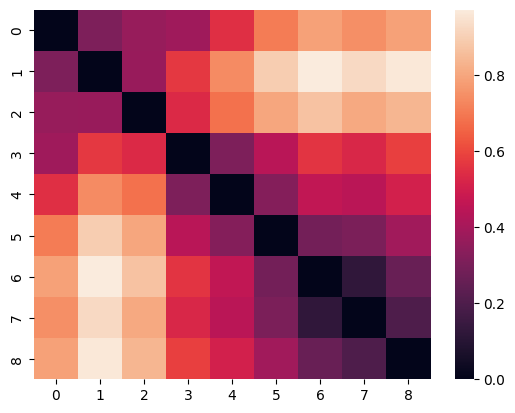

In [24]:
sns.heatmap(dsa_scores)
plt.show()

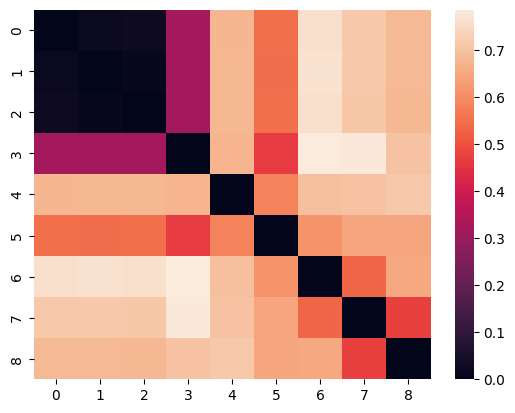

In [25]:
sns.heatmap(procrustes_scores)
plt.show()

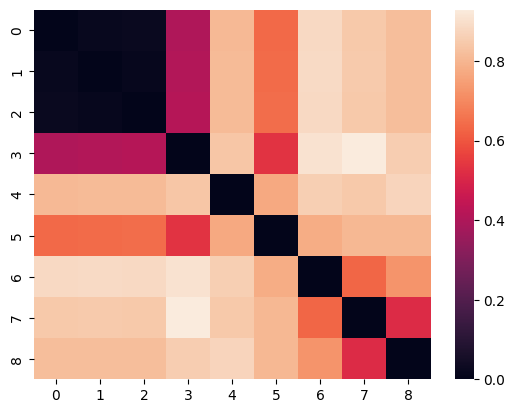

In [26]:
sns.heatmap(cka_scores)
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 